In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_to_load = "./DATA/2019-Oct.csv"
chunksize = 100_000

In [3]:
chunks = pd.read_csv(file_to_load, chunksize=chunksize)

In [4]:
def getRandomDataset(chunks, frac, seed):
    return pd.concat(chunk.sample(frac=frac, random_state=seed) for chunk in chunks)

In [5]:
df = getRandomDataset(chunks, 0.01, 42)

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
75721,2019-10-01 04:02:27 UTC,view,26300089,2053013563584283495,NaN,lucente,271.82,522160547,b16c24b2-6206-47c0-9e80-1b4f286c4d92
80184,2019-10-01 04:07:22 UTC,view,1201366,2053013561059312345,electronics.tablet,acer,180.14,512468978,71bcb984-9eea-43bb-8240-5d7be72f0913
19864,2019-10-01 02:53:49 UTC,view,1005021,2053013555631882655,electronics.smartphone,oppo,386.06,554585696,5b1171d5-8637-4c11-9ed0-e9f7a9fa9079
76699,2019-10-01 04:03:31 UTC,view,8500427,2053013552259662037,NaN,navien,1286.66,515869608,5e372be0-2590-42a1-8e24-f016167158cd
92991,2019-10-01 04:21:04 UTC,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,254.76,512933004,b2db57d2-9804-41d5-baf6-38019a71e6fb


In [7]:
df.describe()

,product_id,category_id,price,user_id
count,4.244880e+05,4.244880e+05,424488.000000,4.244880e+05
mean,1.055723e+07,2.057402e+18,290.059485,5.335368e+08
std,1.186936e+07,1.844728e+16,357.888449,1.857128e+07
min,1.000978e+06,2.053014e+18,0.000000,2.398766e+08
25%,1.005158e+06,2.053014e+18,66.100000,5.158889e+08
50%,5.000576e+06,2.053014e+18,163.195000,5.297250e+08
75%,1.600064e+07,2.053014e+18,358.570000,5.516223e+08
max,6.050000e+07,2.175420e+18,2574.070000,5.662785e+08


In [8]:
def createNaAndUniqueMatrix(df):
    rows = ["Valeurs nulles", "Valeurs uniques"]

    data = {}

    for column in df.columns:    
        na = df[column].isna()
        unique = len(df[column][~na].unique())

        data[column] = [len(df[na]), unique]

    return pd.DataFrame(data, index=rows)

In [9]:
createNaAndUniqueMatrix(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
Valeurs nulles,0,0,0,0,135281,61576,0,0,0
Valeurs uniques,382887,3,59624,599,126,2466,29085,320461,398874


Analysons les 3 valeurs uniques d'event_type

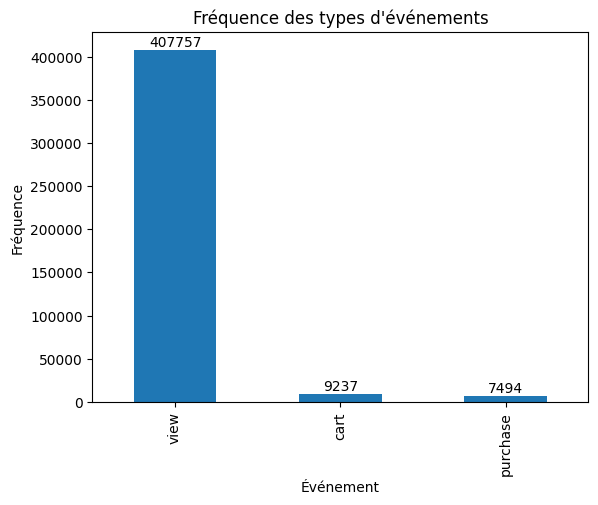

In [10]:
frequences = df["event_type"][df["event_type"].notna()].value_counts()

ax = frequences.plot(kind="bar")

for i,v in enumerate(frequences):
    ax.text(i, v + 0.1, str(v), ha="center", va="bottom")

plt.title("Fréquence des types d'événements")
plt.xlabel("Événement")
plt.ylabel("Fréquence")
plt.show()

On recense donc 407 757 vues, 9237 mises dans un panier et 7494 achats

Quels sont les taux de conversion entre les types d'événements ?

In [17]:
viewToCart = frequences["cart"] / frequences["view"] * 100
cartToPurchase = frequences["purchase"] / frequences["cart"] * 100
viewToPurchase = frequences["purchase"] / frequences["view"] * 100

print(f"Taux de conversion vue => panier : {viewToCart:.2f} %")
print(f"Taux de conversion panier => achat : {cartToPurchase:.2f} %")
print(f"Taux de conversion vue => achat : {viewToPurchase:.2f} %")

Taux de conversion vue => panier : 2.27 %
Taux de conversion panier => achat : 81.13 %
Taux de conversion vue => achat : 1.84 %


Combien d'utilisateurs différents ont fait un achat ?

In [36]:
usersPurchased = len(df["user_id"][df["event_type"] == "purchase"].unique())

itemsPurchasedPerUser = frequences["purchase"] / usersPurchased

maxUserBuy = df[df["event_type"] == "purchase"].groupby("user_id").size().max()
maxSessionBuy = df[df["event_type"] == "purchase"].groupby("user_session").size().max()

print(f"Un total de {usersPurchased} utilisateurs différents ont effectué des achats sur le site")
print(f"Un utilisateur qui achète sur le site achète en moyenne {itemsPurchasedPerUser:.2f} articles")
print(f"L'utilisateur qui a le plus acheté a acheté {maxUserBuy} articles sur le mois")
print(f"La session utilisateur qui a le plus acheté a acheté {maxSessionBuy} articles en une session")

Un total de 7270 utilisateurs différents ont effectué des achats sur le site
Un utilisateur qui achète sur le site achète en moyenne 1.03 articles
L'utilisateur qui a le plus acheté a acheté 8 articles sur le mois
La session utilisateur qui a le plus acheté a acheté 2 articles en une session


Comment évoluent les achats sur le mois ?

In [64]:
datesDayToDay = pd.to_datetime(df["event_time"]).dt.date
purchasesDayToDay = df[df["event_type"] == "purchase"].groupby(datesDayToDay)["event_type"].count()
uniqueDates = datesDayToDay.unique()

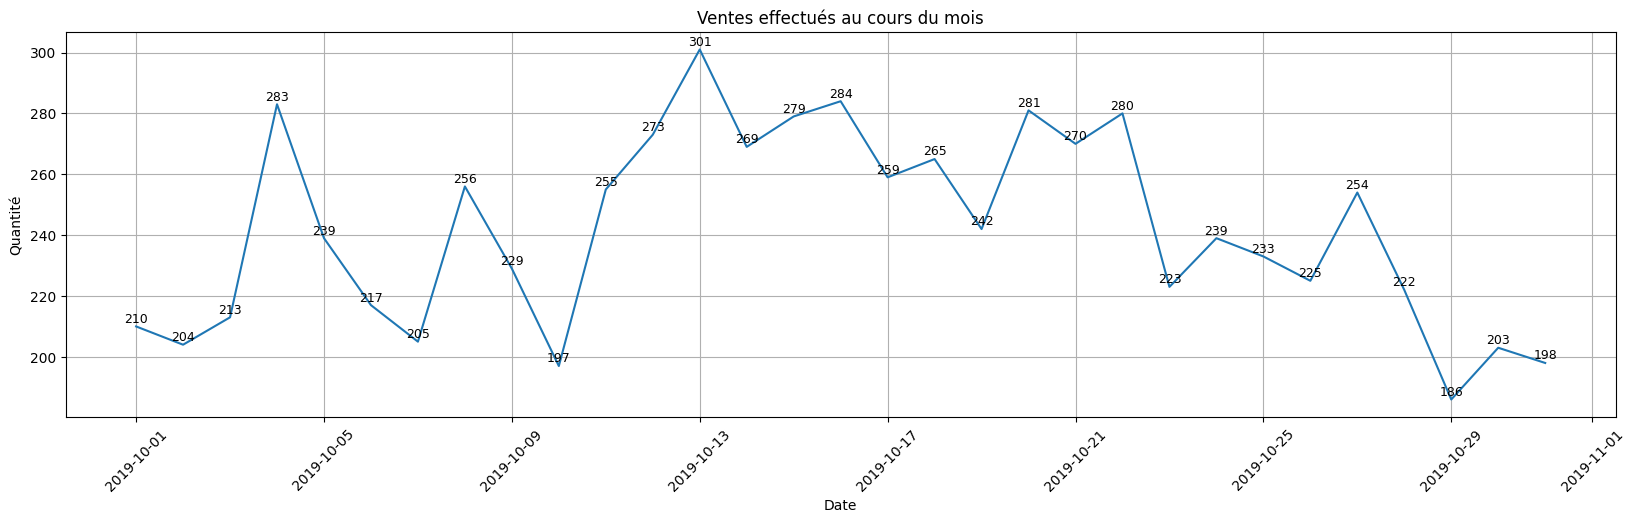

In [67]:
plt.figure(figsize=(20, 5))
plt.plot(uniqueDates, purchasesDayToDay)

for x,y in zip(uniqueDates, purchasesDayToDay):
    plt.text(x, y + 0.3, y, ha="center", va="bottom", fontsize=9)

plt.title("Ventes effectués au cours du mois")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.grid(True)
plt.xticks(rotation=45)

plt.show()